# KBO 타자 OPS 예측

In [3]:
# 메모리 변수 모두 제거
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/mnt')

Mounted at /content/mnt


In [5]:
f = '/content/mnt/MyDrive/데이터/데이콘경진대회/62540_KBO_prediction_data'

In [6]:
sum_hf_yr_OBP = pd.read_csv(f'{f}/sum_hf_yr_OBP.csv')
sum_hf_yr_SLG = pd.read_csv(f'{f}/sum_hf_yr_SLG.csv')

## 3. 모델구축과 검증

### 3.1 데이터 분할

In [7]:
# 30타수 이상의 데이터만 학습
sum_hf_yr_OBP= sum_hf_yr_OBP.loc[sum_hf_yr_OBP['AB']>=30] # P.40 참고
sum_hf_yr_SLG = sum_hf_yr_SLG.loc[sum_hf_yr_SLG['AB']>=30] 

# 2018년 데이터를 test 데이터 2018년 이전은 train 데이터로 나눈다.
OBP_train = sum_hf_yr_OBP.loc[sum_hf_yr_OBP['year'] != 2018]
OBP_test = sum_hf_yr_OBP.loc[sum_hf_yr_OBP['year'] == 2018]

SLG_train = sum_hf_yr_SLG.loc[sum_hf_yr_SLG['year'] != 2018]
SLG_test = sum_hf_yr_SLG.loc[sum_hf_yr_SLG['year'] == 2018]
print(OBP_train.shape, OBP_test.shape, SLG_train.shape, SLG_test.shape)

(872, 9) (150, 9) (872, 9) (150, 9)


In [8]:
def wrmse(v,w,p):
    # v: 실제값
    # w: 타수
    # p: 예측값
    return sum(np.sqrt(((v-p)**2 * w) / sum(w)))

### 3.2 모델 선택

- 릿지, 라쏘

In [10]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# log 단위(1e+01)로 1.e-04 ~ 1.e+01 사이의 구간에 대해 parameter를 탐색한다.
# numpy.logspace(start, stop, num=50, endpoint=True, base=10.0, dtype=None, axis=0) 
lasso_params = {'alpha':np.logspace(-4, 1, 6)} # 10^(-4)~10을 6개로 나눈 배열
ridge_params = {'alpha':np.logspace(-4, 1, 6)} 

# GridSearchCV를 이용하여 dict에 Lasso, Ridege OBP 모델을 저장한다.
OBP_linear_models = {
    'Lasso': GridSearchCV(Lasso(), param_grid=lasso_params).fit(    # GridSearchCV(model,param,scoring,...).fit(X,y)
        OBP_train.iloc[:,-5:], OBP_train['OBP']).best_estimator_,
    'Ridge': GridSearchCV(Ridge(), param_grid=ridge_params).fit(
        OBP_train.iloc[:,-5:], OBP_train['OBP']).best_estimator_,}

# GridSearchCV를 이용하여 dict에 Lasso, Ridge SLG 모델을 저장한다
SLG_linear_models = {
    'Lasso': GridSearchCV(Lasso(), param_grid=lasso_params).fit(
        SLG_train.iloc[:,-5:], SLG_train['SLG']).best_estimator_,
    'Ridge': GridSearchCV(Ridge(),param_grid=ridge_params).fit(
        SLG_train.iloc[:,-5:], SLG_train['SLG']).best_estimator_,}

- 랜덤 포레스트
    - n_estimators : 생성할 tree의 개수
    - max_features : 최대 선택할 특성의 수
        - max_features 값을 크게 하면 random forest의 tree들은 같은 특성을 고려하므로 tree들이 매우 비슷해지고 가장 두드러진 특성을 이용해 데이터에 잘 맞춰집니다.
        - max_features를 낮추면 random forest tree들은 많이 달라지고 각 tree는 데이터에 맞추기 위해 tree의 깊이가 깊어집니다.

In [14]:
import time
from sklearn.ensemble import RandomForestRegressor
start = time.time() # 시작 시간

# 랜덤 포레스트의 parameter 범위 정의
RF_params = {
    'n_estimators' : [50, 100, 150, 200, 300, 500, 1000],
    'max_features' : ['auot', 'sqrt'],
    'max_depth' : [1, 2, 3, 5, 6, 10],
    'min_samples_leaf' : [1, 2, 4],
    'min_samples_split' : [2, 3, 5, 10]
}

# GridSearchCV를 이용하여 dict에 OBP Randomforest 모델을 저장한다.
OBP_RF_models = {
    'RF': GridSearchCV(
        RandomForestRegressor(random_state=42), param_grid=RF_params, n_jobs=-1
        ).fit(OBP_train.iloc[:,-5:], OBP_train['OBP']).best_estimator_}

# GridSearchCV를 이용하여 dict에 SLG Randomforest 모델을 저장한다.
SLG_RF_models = {
    'RF': GridSearchCV(
        RandomForestRegressor(random_state=42), param_grid=RF_params, n_jobs=-1
        ).fit(SLG_train.iloc[:,-5:], SLG_train['SLG']).best_estimator_}

print(f"걸린시간 : {np.round(time.time() - start,3)}초") # 현재시간 – 시작시간(단위 초)

걸린시간 : 2736.49초


- XGBoost(eXtra Gradient Boost)
    - 트리 기반 모델
    - 학습을 진행할 때 오분류된 데이터에 가중치를 부여해 성능을 높이고자 하는 모델

In [18]:
import xgboost as xgb
start = time.time()

# xgboost parmeter space를 정의
XGB_params = {
    'min_child_weight': [1,3, 5,10],
    'gamma': [0.3,0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5,7,10]}

# GridSearchCV를 통해 parameter를 탐색하게 정의
XGB_OBP_gridsearch = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid=XGB_params, n_jobs=-1)
XGB_SLG_gridsearch = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid=XGB_params, n_jobs=-1)

# 모델 학습
XGB_OBP_gridsearch.fit(OBP_train.iloc[:,-5:], OBP_train['OBP'])
XGB_SLG_gridsearch.fit(SLG_train.iloc[:,-5:], SLG_train['SLG'])

print(f"걸린시간 : {np.round(time.time() - start,3)}초") # 현재시간 – 시작시간(단위 초)

[16:42:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:47:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
걸린시간 : 610.031초


- 출루율(OBP) 예측 모델 성능 비교

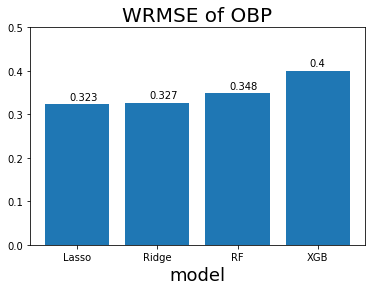

In [22]:
# 테스트 데이터셋(2018년)의 선수들의 OBP를 예측
Lasso_OBP = OBP_linear_models['Lasso'].predict(OBP_test.iloc[:,-5:])
Ridge_OBP = OBP_linear_models['Ridge'].predict(OBP_test.iloc[:,-5:])
RF_OBP = OBP_RF_models['RF'].predict(OBP_test.iloc[:,-5:])
XGB_OBP = XGB_OBP_gridsearch.predict(OBP_test.iloc[:,-5:])

# test 데이터의 WRMSE 계산
wrmse_score = [wrmse(OBP_test['OBP'], OBP_test['AB'], Lasso_OBP),
               wrmse(OBP_test['OBP'], OBP_test['AB'], Ridge_OBP),
               wrmse(OBP_test['OBP'], OBP_test['AB'], RF_OBP),
               wrmse(OBP_test['OBP'], OBP_test['AB'], XGB_OBP)]

x_lab = ['Lasso', 'Ridge', 'RF', 'XGB']
plt.bar(x_lab, wrmse_score)
plt.title('WRMSE of OBP', fontsize=20)
plt.xlabel('model', fontsize=18)
plt.ylabel('', fontsize=18)
plt.ylim(0, 0.5)

for i,v in enumerate(wrmse_score):
    plt.text(i-0.1, v+0.01, str(np.round(v,3))) # x 좌표, y 좌표, 텍스트

plt.show()

- 장타율(SLG) 예측 모델 성능 비교

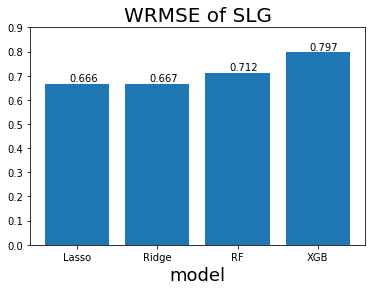

In [23]:
# 테스트 데이터셋(2018년)의 선수들의 SLG를 예측
Lasso_SLG = SLG_linear_models['Lasso'].predict(SLG_test.iloc[:,-5:])
Ridge_SLG = SLG_linear_models['Ridge'].predict(SLG_test.iloc[:,-5:])
RF_SLG = SLG_RF_models['RF'].predict(SLG_test.iloc[:,-5:])
XGB_SLG = XGB_SLG_gridsearch.predict(SLG_test.iloc[:,-5:])

# test데이터 WRMSE 계산
wrmse_score_SLG = [wrmse(SLG_test['SLG'], SLG_test['AB'], Lasso_SLG),
                   wrmse(SLG_test['SLG'], SLG_test['AB'], Ridge_SLG), 
                   wrmse(SLG_test['SLG'], SLG_test['AB'], RF_SLG),
                   wrmse(SLG_test['SLG'], SLG_test['AB'], XGB_SLG)]

x_lab = ['Lasso', 'Ridge', 'RF', 'XGB']

plt.bar(x_lab, wrmse_score_SLG)
plt.title('WRMSE of SLG', fontsize=20)
plt.xlabel('model', fontsize=18)
plt.ylabel('', fontsize=18)
plt.ylim(0, 0.9)

# 막대그래프 위에 값을 표시해준다.
for i, v in enumerate(wrmse_score_SLG):
    plt.text(i-0.1, v + 0.01, str(np.round(v,3))) # x 좌표, y 좌표, 텍스트를 표현한다.
plt.show()

### 3.3 결과 해석과 평가

- 랜덤 포레스트 모델에서의 변수 중요도

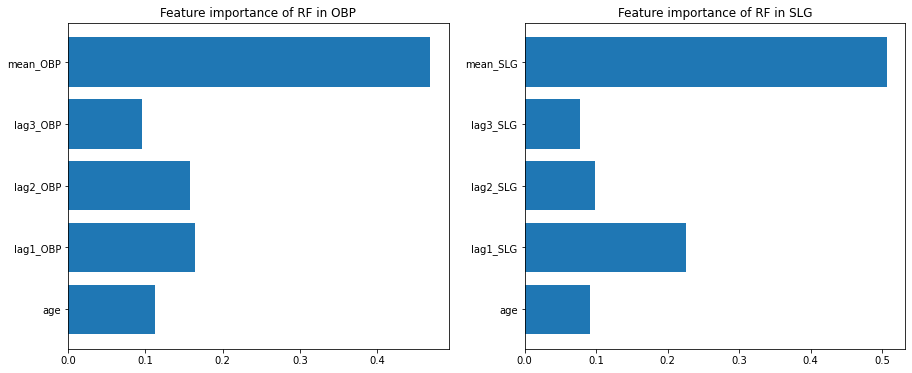

In [25]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1) # 1행 2열의 첫번째(1,1) 그래프
plt.barh(OBP_train.iloc[:,-5:].columns, OBP_RF_models['RF'].feature_importances_)
plt.title('Feature importance of RF in OBP')

plt.subplot(1,2,2)
plt.barh(SLG_train.iloc[:,-5:].columns,SLG_RF_models['RF'].feature_importances_)
plt.title('Feature importance of RF in SLG')
plt.show()

- 라쏘와 릿지 회귀모델의 변수 중요도

In [26]:
# Lasso에서 GridSearchCV로 탐색한 최적의 alpha값 출력
print('Alpha: ', OBP_linear_models['Lasso'].alpha)
# Lasso model의 선형 계수 값 출력
display(pd.DataFrame(OBP_linear_models['Lasso'].coef_.reshape(-1,5),
             columns=OBP_train.iloc[:,-5:].columns, index=['coefficient']))

print('Alpha : ', SLG_linear_models['Lasso'].alpha)
display(pd.DataFrame(SLG_linear_models['Lasso'].coef_.reshape(-1, 5),
                     columns=SLG_train.iloc[:,-5:].columns, index = ['coefficient']))

Alpha:  0.0001


,age,lag1_OBP,lag2_OBP,lag3_OBP,mean_OBP
coefficient,0.003195,0.018249,0.0,0.0,0.864913


Alpha :  0.0001


,age,lag1_SLG,lag2_SLG,lag3_SLG,mean_SLG
coefficient,0.0049,0.081209,0.0,-0.0,0.836453


- 라쏘 학습과정 시각화

..

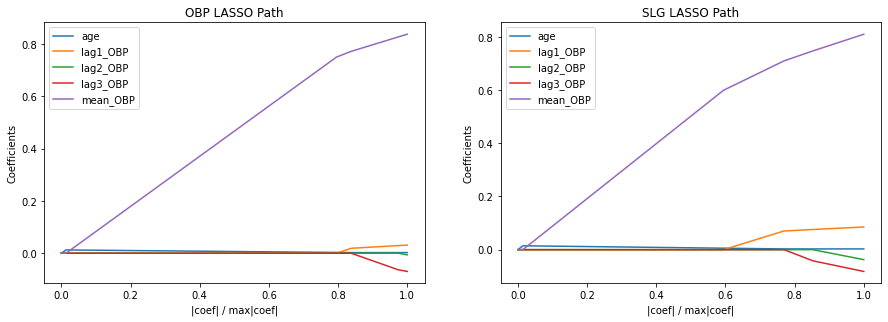

In [35]:
from sklearn.linear_model import lars_path
plt.figure(figsize=(15,4.8)) # 그래프 크기 지정
plt.subplot(1,2,1) # 1행 2열의 첫 번째(1행, 1열) 그래프

# OBP 모델의 alpha 값의 변화에 따른 계수의 변화를 alpha, coefs에 저장한다.
alpha, _, coefs = lars_path(OBP_train.iloc[:,-5:].values, OBP_train['OBP'],
                            method='lasso', verbose=True)
# 피처별 alpha 값에 따른 선형 모델 계수의 절댓값의 합 
xx = np.sum(np.abs(coefs.T), axis=1)
# 계수의 절댓값 중 가장 큰 값으로 alpha에 따른 피처의 계수의 합을 나눈다. 
xx /= xx[-1]

plt.plot(xx, coefs.T) # coefs.T: 각 alpha에 대한 선형 모델 계수(6x5)
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('OBP LASSO Path')
plt.axis('tight')
plt.legend(OBP_train.iloc[:,-5:].columns)

plt.subplot(1,2,2) # 1행 2열의 두 번째(1행, 2열) 그래프
# SLG 모델에서 alpha 값의 변화에 따른 계수의 변화를 alpha, coefs에 저장한다.
alphas, _, coefs = lars_path(SLG_train.iloc[:,-5:].values, SLG_train['SLG'],
                             method='lasso', verbose=True)
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('SLG LASSO Path')
plt.axis('tight')
plt.legend(OBP_train.iloc[:,-5:].columns)
plt.show()

# 왼쪽으로 갈수록 패널티 값이 커져 계수가 0으로 수렴
# 0으로 늦게 수렴할수록 중요한 변수

## 4. 성능 향상을 위한 방법

### 4.1 앙상블
- 여러 모델의 결과를 종합해 사용하는 것
- 여러 모델의 예측 결과를 더해 평균을 내면 하나의 모델을 사용하는 것보다 더 좋은 결과를 보일 때가 많다.
- 보통 **서로 다른 알고리즘**이면서 **비슷한 성능**을 보이는 결과를 결합할 때 좋은 성능을 보인다.

In [41]:
# 성능이 가장 좋았던 Lasso와 선형회귀 모델이 아니면서 성능이 비슷했던 랜덤 포레스트를 이용하여 앙상블
print('OBP model averaging: ', wrmse(OBP_test['OBP'], OBP_test['AB'], (Lasso_OBP+RF_OBP)/2))
print('SLG model averaging: ', wrmse(SLG_test['SLG'], OBP_test['AB'], (Lasso_SLG + RF_SLG) / 2))

OBP model averaging:  0.332457465201058
SLG model averaging:  0.6799104610118815


### 4.2 단순화된 모델 생성
- age, lag1_OBP, mean_OBP를 사용한 모형과 age, lag1_OBP, mean_OBP, lag1_BB, lag1_TB, lag1_RBI을 사용한 모형을 랜덤 포레스트 모델과 GridSearchCV를 사용하여 학습&예측
- WRMSE 결과를 비교했을 때 단순모형이 0.002만큼 더 컸음 => 매우 미세한 차이
- 두 모델이 비슷한 성능을 보이고 있다면 분석을 진행할 때 가능한 변수가 적은 모델을 선택해야 함.
- 예측을 진행할 때 변수가 많을수록 과적합 이슈가 발생할 수 있기 때문

### 4.3 테스트 데이터 정제
- test데이터를 2018년 데이터가 아닌 2019년 데이터로 변경하여 예측

In [56]:
regular_season_df = pd.read_csv(f'{f}/regular_season_df.csv')

In [57]:
submission = pd.read_csv(f'{f}/submission.csv')
submission['year'] = 2019 # 연도 기입
submission.head()

,batter_id,batter_name,year
0,1,강경학,2019
1,2,강구성,2019
2,3,강민국,2019
3,4,강민호,2019
4,5,강백호,2019


In [62]:
# 2019년의 Age(나이) 계산
batter_year_born = regular_season_df[['batter_id', 'batter_name', 'year_born']].copy()
# 중복선수 제거
batter_year_born = batter_year_born.drop_duplicates().reset_index(drop=True)

submission = submission.merge(batter_year_born, how='left', on=['batter_id', 'batter_name'])
submission['age'] = submission['year']-submission['year_born'].apply(lambda x: int(x.split('년')[0]))
submission.head()

,batter_id,batter_name,year,year_born,age
0,1,강경학,2019,1992년 08월 11일,27
1,2,강구성,2019,1993년 06월 09일,26
2,3,강민국,2019,1992년 01월 10일,27
3,4,강민호,2019,1985년 08월 18일,34
4,5,강백호,2019,1999년 07월 29일,20


In [63]:
# submission OBP, SLG 파일 2개 만들어 합치기 
submission_OBP = submission.copy()
submission_SLG = submission.copy()

In [65]:
# 앞서 전처리한 데이터를 이용해 평균 성적 기입
submission_OBP = submission_OBP.merge(
    sum_hf_yr_OBP[['batter_name','mean_OBP']].drop_duplicates().reset_index(drop=True),
    how = 'left', on ='batter_name')

# 앞서 전처리한 데이터를 이용해 과거 성적 값 채우기
for i in [1,2,3]:
    temp_lag_df = sum_hf_yr_OBP.loc[
        (sum_hf_yr_OBP['year'] == (2019 - i)) &
        (sum_hf_yr_OBP['AB']>=30),['batter_name','OBP']].copy()
    temp_lag_df.rename(columns={'OBP':'lag'+str(i)+'_OBP'}, inplace=True)
    submission_OBP = submission_OBP.merge(temp_lag_df, how='left', on='batter_name')

submission_OBP.head()

,batter_id,batter_name,year,year_born,age,mean_OBP,lag1_OBP,lag2_OBP,lag3_OBP
0,1,강경학,2019,1992년 08월 11일,27,0.337880,0.423611,0.285714,0.222222
1,2,강구성,2019,1993년 06월 09일,26,NaN,NaN,NaN,NaN
2,3,강민국,2019,1992년 01월 10일,27,NaN,NaN,NaN,NaN
3,4,강민호,2019,1985년 08월 18일,34,0.358187,0.328990,0.386076,0.441860
4,5,강백호,2019,1999년 07월 29일,20,0.356164,0.355685,NaN,NaN


In [80]:
# 앞서 전처리한 데이터로 평균 SLG 값 기입
submission_SLG = submission_SLG.merge(
    sum_hf_yr_SLG[['batter_name','mean_SLG']].drop_duplicates().reset_index(drop=True),
    how='left', on='batter_name')

# 앞서 전처리한 데이터에서 과거 SLG 값 채우기
for i in [1,2,3]:
    temp_lag_df = sum_hf_yr_SLG.loc[(sum_hf_yr_SLG['year'] == (2019 - i)) &
        (sum_hf_yr_SLG['AB']>=30),['batter_name','SLG']].copy()
    
    temp_lag_df.rename(columns={'SLG':'lag'+str(i)+'_SLG'}, inplace=True)
    
    submission_SLG = submission_SLG.merge(temp_lag_df, how='left', on='batter_name')

- 결측치 처리
    - 앞에서는 결측치를 제거하고 모델링했지만 지금은 대회에 제출해야 할 선수의 데이터가 사라지기 때문에 삭제할 수 없음
    - 따라서 평균 성적이 결측치인 선수들(4가지 케이스)에 대해 결측치를 처리 

- **OBP**

In [66]:
submission_OBP['batter_name'].loc[submission_OBP['mean_OBP'].isna()].values

array(['강구성', '강민국', '강상원', '고명성', '김응민', '김종덕', '김주찬', '김철호', '김태연',
       '김태진', '김형준', '나원탁', '남태혁', '박광열', '박기혁', '백민기', '샌즈', '신범수',
       '신성현', '양종민', '윤정우', '이동훈', '이범호', '이병휘', '이성곤', '이인행', '이종욱',
       '이진영', '이창진', '장승현', '장시윤', '전민재', '전병우', '정경운', '정성훈', '조홍석',
       '최원제', '홍창기'], dtype=object)

- Case1 : 정규시즌 데이터에는 있으나 일별 데이터에는 기록이 없어 결측치가 생긴 선수들

In [67]:
for batter_name in ["김주찬", "이범호"]:
     # 30타수 이상인 해당선수의 인덱스(Boolean)
    cond_regular = (regular_season_df['AB'] >= 30) & \
                   (regular_season_df['batter_name'] == batter_name)
    
    # 타수를 고려해 평균 OBP 계산
    mean_OBP = sum(regular_season_df.loc[cond_regular,'AB'] * \
                   regular_season_df.loc[cond_regular,'OBP']) / \
               sum(regular_season_df.loc[cond_regular,'AB'])
    
    submission_OBP.loc[(submission_OBP['batter_name'] == batter_name),'mean_OBP'] = \
        mean_OBP
    
    # regular_season_Batter으로부터 1, 2, 3년 전 성적 구하기
    cond_sub = submission_OBP['batter_name'] == batter_name
    submission_OBP.loc[cond_sub,'lag1_OBP'] = regular_season_df.loc[
        (cond_regular) & (regular_season_df['year']==2018),'OBP'].values
    submission_OBP.loc[cond_sub,'lag2_OBP'] = regular_season_df.loc[
        (cond_regular) & (regular_season_df['year']==2017),'OBP'].values
    submission_OBP.loc[cond_sub,'lag3_OBP'] = regular_season_df.loc[
        (cond_regular) & (regular_season_df['year']==2016),'OBP'].values

- Case2 : 1998년 혹은 1999년 출생의 신인급 선수들
    - 나이가 어린 경우 이후 성적이 더 높아지는 경향이 있으므로 2018 시즌 성적으로 출루율의 평균 대체

In [69]:
season_OBP_mean = pd.read_csv(f'{f}/season_OBP_mean.csv')

In [70]:
for i in np.where(submission_OBP['batter_name'].isin(["고명성","전민재","김철호","신범수","이병휘"])):
    #submission_OBP.loc[i,'mean_OBP'] = season_OBP_mean.loc[season_OBP_mean['year']==2018,'mean_OBP'].values
    submission_OBP.loc[i,'mean_OBP'] = season_OBP_mean.loc[season_OBP_mean['year']==2018,'mean_OBP']

- Case3 : 2018년 하반기의 성적만 있는 경우

In [71]:
for batter_name in ["전병우","샌즈"]:
    # 30 타수 이상인 해당 선수의 index 추출
    cond_regular = (regular_season_df['AB']>=30) & \
                   (regular_season_df['batter_name']==batter_name) 

# 타수를 고려해 선수의 평균 OBP계산
mean_OBP = sum(regular_season_df.loc[cond_regular,'AB'] * \
               regular_season_df.loc[cond_regular,'OBP']) / \
           sum(regular_season_df.loc[cond_regular,'AB'])
    
submission_OBP.loc[(submission_OBP['batter_name'] == batter_name),'mean_OBP'] = mean_OBP

cond_sub = submission_OBP['batter_name'] == batter_name

# 2018년 데이터로부터 2019년의 1년 전 성적 기입
submission_OBP.loc[cond_sub,'lag1_OBP'] = regular_season_df.loc[
    (cond_regular)&(regular_season_df['year']==2018),'OBP'].values

- Case4 : 은퇴를 했거나 1군 수준의 성적을 보여주지 못하는 선수들

In [75]:
player_OBP_mean = pd.read_csv(f'{f}/player_OBP_mean.csv')

In [76]:
# 평균 성적이 결측치인 선수들에 대해 평균 OBP의 하위 25% 성적 기입
submission_OBP.loc[submission_OBP['mean_OBP'].isna(),'mean_OBP'] = \
    np.quantile(player_OBP_mean['mean_OBP'],0.25)

In [77]:
# 결측치 처리하는 함수 정의
def lag_na_fill(data_set, var_name, past, season_var_mean_data):
    # data_Set: 이용할 데이터셋
    # var_name: 시간 변수를 만들 변수 이름
    # past: 몇 년 전 변수를 만들지 결정
    # season_var_name_mean_data season별로 var_name의 평균을 구한 데이터
  
    for i in range(0,len(data_set)):
        if np.isnan(data_set["lag"+str(past)+"_"+var_name][i]):
            data_set.loc[i,["lag"+str(past)+"_"+var_name]] = (
                data_set["mean" + "_" + var_name][i] + season_var_mean_data.loc[
                    season_var_mean_data['year'] == (data_set['year'][i] - past),
                    "mean_" + var_name].iloc[0]
                ) / 2
    return data_set

- 1,2,3년 전 성적의 결측치 처리

In [78]:
for i in [1,2,3]: 
    # i년 전 OBP 결측치 제거
    submission_OBP = lag_na_fill(submission_OBP, 'OBP', i, season_OBP_mean)
submission_OBP.head()

,batter_id,batter_name,year,year_born,age,mean_OBP,lag1_OBP,lag2_OBP,lag3_OBP
0,1,강경학,2019,1992년 08월 11일,27,0.337880,0.423611,0.285714,0.222222
1,2,강구성,2019,1993년 06월 09일,26,0.304124,0.329991,0.330297,0.336224
2,3,강민국,2019,1992년 01월 10일,27,0.304124,0.329991,0.330297,0.336224
3,4,강민호,2019,1985년 08월 18일,34,0.358187,0.328990,0.386076,0.441860
4,5,강백호,2019,1999년 07월 29일,20,0.356164,0.355685,0.356317,0.362245


- **SLG**

In [81]:
submission_SLG['batter_name'].loc[submission_SLG['mean_SLG'].isna()].values

array(['강구성', '강민국', '강상원', '고명성', '김응민', '김종덕', '김주찬', '김철호', '김태연',
       '김태진', '김형준', '나원탁', '남태혁', '박광열', '박기혁', '백민기', '샌즈', '신범수',
       '신성현', '양종민', '윤정우', '이동훈', '이범호', '이병휘', '이성곤', '이인행', '이종욱',
       '이진영', '이창진', '장승현', '장시윤', '전민재', '전병우', '정경운', '정성훈', '조홍석',
       '최원제', '홍창기'], dtype=object)

- Case1 : 정규시즌 데이터에는 있으나 일별 데이터에는 기록이 없어 결측치가 생긴 선수들

In [82]:
for batter_name in ["김주찬", "이범호"]:
     # mean_SLG 계산
    cond_regular = (regular_season_df['AB'] >= 30) & \
                   (regular_season_df['batter_name'] == batter_name)
    
    # 타수를 고려해 선수의 평균 SLG 계산
    mean_SLG = sum(regular_season_df.loc[cond_regular,'AB'] * \
                   regular_season_df.loc[cond_regular,'SLG']) / \
               sum(regular_season_df.loc[cond_regular,'AB'])
    
    submission_SLG.loc[(submission_SLG['batter_name'] == batter_name), 'mean_SLG'] = \
        mean_SLG
    
    # regular_season_Batter으로부터 1, 2, 3년 전 성적 구하기
    cond_sub = submission_SLG['batter_name'] == batter_name
    
    submission_SLG.loc[cond_sub,'lag1_SLG'] = regular_season_df.loc[
        (cond_regular) & (regular_season_df['year'] == 2018),'SLG'].values
    submission_SLG.loc[cond_sub,'lag2_SLG'] = regular_season_df.loc[
        (cond_regular) & (regular_season_df['year'] == 2017),'SLG'].values
    submission_SLG.loc[cond_sub,'lag3_SLG'] = regular_season_df.loc[
        (cond_regular) & (regular_season_df['year'] == 2016),'SLG'].values

- Case2 : 1998년 혹은 1999년 출생의 신인급 선수들
    - 나이가 어린 경우 이후 성적이 더 높아지는 경향이 있으므로 2018 시즌 성적으로 출루율의 평균 대체

In [84]:
season_SLG_mean = pd.read_csv(f'{f}/season_SLG_mean.csv')

In [85]:
for i in np.where(submission_SLG['batter_name'].isin(
    ["고명성","전민재","김철호","신범수","이병휘"])):
     # 위의 해당 선수들의 평균 SLG 평균값으로 대체
    #submission_SLG.loc[i,'mean_SLG'] = season_SLG_mean.loc[season_SLG_mean['year']==2018,'mean_SLG'].values
    submission_SLG.loc[i,'mean_SLG'] = \
        season_SLG_mean.loc[season_SLG_mean['year']==2018,'mean_SLG']

- Case3 : 2018년 하반기의 성적만 있는 경우

In [86]:
for batter_name in ["전병우","샌즈"]:
    
    # 30타수 이상인 해당선수의 인덱스(Boolean) 
    cond_regular = (regular_season_df['AB']>=30)&\
(regular_season_df['batter_name']==batter_name)

# 타수를 고려한 평균 SLG 계산
mean_SLG = sum(regular_season_df.loc[cond_regular,'AB']*
regular_season_df.loc[cond_regular,'SLG']) / sum(regular_season_df.loc[cond_regular,'AB'])

# 해당 선수의 평균 SLG 값 기입
submission_SLG.loc[(submission_SLG['batter_name'] == batter_name),
'mean_SLG'] = mean_SLG

# 해당 선수의 1년 전 SLG값 기입
cond_sub = submission_SLG['batter_name'] == batter_name
submission_SLG.loc[cond_sub,'lag1_SLG'] = regular_season_df.loc[(cond_regular)&
(regular_season_df['year']==2018),'SLG'].values

- Case4 : 은퇴를 했거나 1군 수준의 성적을 보여주지 못하는 선수들

In [87]:
player_SLG_mean = pd.read_csv(f'{f}/player_SLG_mean.csv')

In [88]:
# 평균 성적이 결측치인 선수들에 대해 평균 SLG의 하위 25% 성적 기입
submission_SLG.loc[submission_SLG['mean_SLG'].isna(),'mean_SLG'] = \
    np.quantile(player_SLG_mean['mean_SLG'],0.25)

- 1,2,3년 전 성적의 결측치 처리

In [89]:
for i in [1,2,3]:
    # i년 전 SLG 성적 결측치 처리
    submission_SLG = lag_na_fill(submission_SLG, 'SLG', i, season_SLG_mean)
submission_SLG.head()

,batter_id,batter_name,year,year_born,age,mean_SLG,lag1_SLG,lag2_SLG,lag3_SLG
0,1,강경학,2019,1992년 08월 11일,27,0.332527,0.523810,0.256098,0.222222
1,2,강구성,2019,1993년 06월 09일,26,0.326923,0.391429,0.385754,0.385397
2,3,강민국,2019,1992년 01월 10일,27,0.326923,0.391429,0.385754,0.385397
3,4,강민호,2019,1985년 08월 18일,34,0.466540,0.487273,0.548736,0.577689
4,5,강백호,2019,1999년 07월 29일,20,0.523719,0.532051,0.484152,0.483795


- 2019년 KBO 상반기 타자 OPS 예측 결과 도출

In [91]:
# 가장 성능이 좋았던 모델 사용(나의 경우 둘 다 Lasso였지만 책의 내용 대로 실행)
# Random Forests를 이용해 OBP 예측
predict_OBP = OBP_RF_models['RF'].predict(submission_OBP.iloc[:,-5:]) 
# Lasso를 이용해 SLG 예측
predict_SLG = SLG_linear_models ['Lasso'].predict(submission_SLG.iloc[:,-5:])

In [92]:
final_submission = submission[['batter_id','batter_name']]
final_submission['OPS'] = predict_SLG + predict_OBP # OBP + SLG = OPS 
final_submission.head(10) # 최종 데이터 셋

,batter_id,batter_name,OPS
0,1,강경학,0.503957
1,2,강구성,0.687933
2,3,강민국,0.696609
3,4,강민호,0.958395
4,5,강백호,0.751592
5,8,강상원,0.661807
6,9,강승호,0.505642
7,11,강진성,0.656007
8,12,강한울,0.672859
9,16,고명성,0.640507


### 4.4 반발계수의 변화
- 2019년이라는 시즌의 특징을 반영하여 KBO 타자의 성적을 더 정확히 예측
- 2019년 시즌에는 공인구의 반발계수의 변화가 있음
- 반발계수란 물체가 충돌했을 때 충돌 전후 속도의 비
- 동일한 힘으로 공을 쳤을 때, 공이 이전 공(반발계수를 낮추기 전의 공)보다 더 조금 날아간다.
- 따라서 선수의 역량이 같더라도 어느 정도의 성적 하락 현상이 발생할 수 있다.
- 공인구 반발계수를 똑같이 조정한 적이 있는 일본에서는 홈런이 이전 시즌보다 약 절반으로 줄었다.

In [94]:
# 시즌별 전체 OBP 계산(30타수 이상인 선수들의 기록만 이용)
season_OBP = \
    regular_season_df.loc[regular_season_df['AB'] >= 30].groupby('year').agg(
        {'AB':'sum', 'H':'sum', 'BB':'sum', 'HBP':'sum', 'SF':'sum'}).reset_index()

season_OBP['OBP'] = season_OBP[['H','BB','HBP']].sum(axis=1) / \
                    season_OBP[['AB','BB','HBP','SF']].sum(axis=1)

# 시즌별 전체 SLG 계산(30타수 이상인 선수들의 기록만 이용)
season_SLG = \
    regular_season_df.loc[regular_season_df['AB']>=30].groupby('year').agg(
        {'AB':'sum', 'H':'sum', '2B':'sum', '3B':'sum', 'HR':'sum'}).reset_index()

season_SLG['SLG'] = ((season_SLG['H'] - season_SLG[['2B','3B','HR']].sum(axis=1)) + \
                     season_SLG['2B']*2+season_SLG['3B']*3+ season_SLG['HR']*4) / \
                    season_SLG['AB']

# season_OBP와 season_SLG를 병합 후 season_OPS를 생성해 OPS 계산
season_OPS = pd.merge(season_OBP[['year','OBP']],season_SLG[['year', 'SLG']], on = 'year')
season_OPS['OPS'] = season_OPS['OBP'] + season_OPS['SLG']

# 시즌별 전체 홈런 수와 한 선수당 평균 홈런 수 계산
season_HR = regular_season_df.loc[regular_season_df['AB']>=30].groupby('year').agg(
    {'HR':['sum','mean','count']}).reset_index()
season_HR.columns = ['year', 'sum_HR', 'mean_HR', 'count']

# 기존의 OPS 데이터셋과 병합
season_OPS = season_OPS.merge(season_HR,on ='year' ,how='left')
display(season_OPS.tail())

,year,OBP,SLG,OPS,sum_HR,mean_HR,count
21,2014,0.368970,0.446302,0.815272,1013,7.235714,140
22,2015,0.362742,0.434129,0.796871,1222,7.685535,159
23,2016,0.368325,0.443871,0.812196,1267,7.918750,160
24,2017,0.356469,0.444584,0.801053,1450,8.285714,175
25,2018,0.355858,0.455936,0.811794,1726,9.806818,176


In [99]:
#2018년의 평균 홈런 개수를 시즌별 평균 홈런 수에서 뺀다(HR_diff)
season_OPS['HR_diff'] = season_OPS['mean_HR'] - season_OPS['mean_HR'].iloc[-1]
difference = season_OPS.sort_values(by = 'HR_diff')[['year','OPS','HR_diff']]
display(difference.reset_index(drop=True).head(12))

,year,OPS,HR_diff
0,2012,0.703301,-5.799242
1,2013,0.748820,-4.891325
2,2006,0.709301,-4.806818
3,2008,0.741542,-4.671987
4,2011,0.735087,-4.564883
5,2007,0.730715,-4.451555
6,2005,0.740615,-3.543660
7,2010,0.770265,-2.623332
8,2014,0.815272,-2.571104
9,2004,0.751737,-2.500696


In [100]:
# 2000년도 이전의 데이터 수가 충분치 않아 고려하지 않는다.
season_OPS.loc[season_OPS['year']>2000]

,year,OBP,SLG,OPS,sum_HR,mean_HR,count,HR_diff
8,2001,0.366585,0.454593,0.821178,199,7.653846,26,-2.152972
9,2002,0.343798,0.424739,0.768536,274,8.838710,31,-0.968109
10,2003,0.353936,0.427291,0.781227,301,7.717949,39,-2.088869
11,2004,0.344181,0.407556,0.751737,358,7.306122,49,-2.500696
12,2005,0.344851,0.395764,0.740615,357,6.263158,57,-3.543660
13,2006,0.334390,0.374912,0.709301,345,5.000000,69,-4.806818
14,2007,0.346222,0.384493,0.730715,407,5.355263,76,-4.451555
15,2008,0.350637,0.390905,0.741542,457,5.134831,89,-4.671987
16,2009,0.359326,0.429237,0.788563,806,8.141414,99,-1.665404
17,2010,0.356988,0.413278,0.770265,783,7.183486,109,-2.623332


In [101]:
final_submission['OPS'] = final_submission['OPS'] - 0.038
display(final_submission.head(10))
final_submission.to_csv(f'{f}/final_submission.csv', index=False) # 최종 제출파일 생성

,batter_id,batter_name,OPS
0,1,강경학,0.465957
1,2,강구성,0.649933
2,3,강민국,0.658609
3,4,강민호,0.920395
4,5,강백호,0.713592
5,8,강상원,0.623807
6,9,강승호,0.467642
7,11,강진성,0.618007
8,12,강한울,0.634859
9,16,고명성,0.602507
